In [75]:
from __future__ import print_function
import time

import sys
import os
from skimage.transform import resize
from skimage.io import imsave, imread, imshow
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, Dropout, merge, Cropping2D, MaxPooling2D, Conv2DTranspose,UpSampling2D,Permute,Reshape,Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras import backend as K
K.set_image_data_format('channels_last')  # TF dimension ordering in this code
img_rows = 512
img_cols = 512
smooth=1


In [192]:
import scipy
thresh_indices=[0,85,170,255]
def construct_full_masks():
    construct_data_path = os.path.join(data_path, 'construct')
    train_data_path = os.path.join(data_path, 'train')

    images = os.listdir(construct_data_path)
    total = int(len(images) / 3) #3files each: epi,dermi,nerv
    i=0
    for img_name in images:
        if '_mask' in img_name:
            continue  
        img_mask1_name = img_name.split('.')[0] + '_epi_mask.tif'
        img_mask2_name = img_name.split('.')[0] + '_dermi_mask.tif'
        img_mask3_name = img_name.split('.')[0] + '_nerve_mask.tif'
        
        
        img = imread(os.path.join(train_data_path, img_name), as_gray=True)
        img_mask1 = imread(os.path.join(construct_data_path, img_mask1_name), as_gray=True, plugin="pil")
        img_mask2 = imread(os.path.join(construct_data_path, img_mask2_name), as_gray=True, plugin="pil")
        img_mask3 = imread(os.path.join(construct_data_path, img_mask3_name), as_gray=True, plugin="pil")
        
        mask = np.zeros_like(img_mask1)

        epi=np.where(img_mask1>0)
        mask[epi]=85

        derm = np.where(img_mask2>0)
        mask[derm]=255

        nerv = np.where(img_mask3>0)
        mask[nerv]=170
        
        imsave(os.path.join(train_data_path, str(img_name.split('.')[0]) + '_mask.tif'), mask)
        


def create_training_data_4class(n_classes=4):
    data_path=''
    train_data_path = os.path.join(data_path, 'train')
    images = os.listdir(train_data_path)
    #print (images)
    total = int(len(images) / 2)
    #print("total is",total)
    imgs = np.ndarray((total, img_rows, img_cols), dtype=np.uint8)
    img_masks = np.ndarray((total, img_rows, img_cols,n_classes), dtype=np.uint8)
    i=0
    for img_name in images:
        
        if '_mask' in img_name:
            continue   
        #print (img_name)
        img_mask_name = img_name.split('.')[0] + '_mask.tif'        
        
        img = imread(os.path.join(train_data_path, img_name), as_gray=True)
        mask = imread(os.path.join(train_data_path, img_mask_name), as_gray=True, plugin="pil")
        
        real_mask = np.zeros([mask.shape[0], mask.shape[1], n_classes])
        for class_ in range(n_classes-1):
            real_mask[:,:,class_] = (mask[:,:] >= thresh_indices[class_]) * (mask[:,:] <  thresh_indices[class_+1])
        real_mask[:,:,-1] = (mask[:,:] >= thresh_indices[-1])
        real_mask = real_mask.astype(np.uint8)
        imgs[i]=img
        #print (img)
        img_masks[i]=real_mask
        print('Done: {0}/{1} images'.format(i, total))
        i += 1
    
    rotated_img90=scipy.ndimage.rotate(imgs,90,axes=(1,2))
    imgs=np.concatenate((imgs,rotated_img90))
    
    rotated_img180=scipy.ndimage.rotate(imgs,180,axes=(1,2))
    imgs=np.concatenate((imgs,rotated_img180))
    
    rotated_img270=scipy.ndimage.rotate(imgs,270,axes=(1,2))
    imgs=np.concatenate((imgs,rotated_img270))
    
    imgs=np.concatenate((imgs,np.flip(imgs,axis=1)))
    imgs=np.concatenate((imgs,np.flip(imgs,axis=2)))
    
    
    rotated_mask90=scipy.ndimage.rotate(img_masks,90,axes=(1,2))
    img_masks=np.concatenate((img_masks,rotated_mask90))
    
    rotated_mask180=scipy.ndimage.rotate(img_masks,180,axes=(1,2))
    img_masks=np.concatenate((img_masks,rotated_mask180))
    
    rotated_mask270=scipy.ndimage.rotate(img_masks,270,axes=(1,2))
    img_masks=np.concatenate((img_masks,rotated_mask270))
    
    img_masks=np.concatenate((img_masks,np.flip(img_masks,axis=1)))
    img_masks=np.concatenate((img_masks,np.flip(img_masks,axis=2)))
    
    
    print(imgs.shape)
    print(img_masks.shape) 
    print('Loading done.')
    np.save('imgs_train.npy', imgs)
    np.save('imgs_mask_train.npy', img_masks)
    print('Saving to .npy files done.')

#construct_full_masks()
create_training_data_4class()

Done: 0/23 images
Done: 1/23 images
Done: 2/23 images
Done: 3/23 images
Done: 4/23 images
Done: 5/23 images
Done: 6/23 images
Done: 7/23 images
Done: 8/23 images
Done: 9/23 images
Done: 10/23 images
Done: 11/23 images
Done: 12/23 images
Done: 13/23 images
Done: 14/23 images
Done: 15/23 images
Done: 16/23 images
Done: 17/23 images
Done: 18/23 images
Done: 19/23 images
Done: 20/23 images
Done: 21/23 images
Done: 22/23 images
(736, 512, 512)
(736, 512, 512, 4)
Loading done.
Saving to .npy files done.


In [196]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [197]:
#this model theoretically works

import keras
def get_unet():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Dropout(0.2)(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Dropout(0.2)(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(n_classes, (1, 1), activation='softmax')(conv9)
    #perm=Permute((2,3,1))(conv10)
    #flat = Reshape((img_rows*img_cols, n_classes))(perm)
    soft = Activation('sigmoid')(conv10)


    
    

    model = Model(inputs = [inputs], outputs = [soft])
    #keras.utils.print_summary(model, line_length=None, positions=None, print_fn=None)

    
    model.compile(optimizer='sgd', loss="categorical_crossentropy",metrics=['accuracy'])
    #model.compile(optimizer='sgd', loss=dice_coef_loss,metrics=[dice_coef])
       


    return model

In [198]:
n_classes=4
def preprocess_img(imgs,num_images=1):
    imgs_p = imgs[..., np.newaxis]
    print ("img shape: ",imgs_p.shape)

    return imgs_p

In [200]:

imgs_train = np.load('imgs_train.npy').astype('float32')
imgs_mask_train = np.load('imgs_mask_train.npy').astype('float32')
print(np.unique(imgs_train))
print(np.unique(imgs_mask_train))

print(imgs_train.shape)



[  0.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.
  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.
  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.
  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.
  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138.
 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152.
 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166.
 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180.
 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194.
 195. 196. 197. 198. 199. 200. 201. 202. 203. 204. 205. 206. 207. 208.
 209. 

In [201]:
"""masktest=imgs_mask_train[0]
print(masktest.shape)
masktest=np.moveaxis(masktest,2,0)
print(masktest.shape) #4 channels of one mask
print (masktest[0])
print (np.unique(masktest[0]))
print (np.unique(masktest[1]))
print (np.unique(masktest[2]))
print (np.unique(masktest[3]))
"""

'masktest=imgs_mask_train[0]\nprint(masktest.shape)\nmasktest=np.moveaxis(masktest,2,0)\nprint(masktest.shape) #4 channels of one mask\nprint (masktest[0])\nprint (np.unique(masktest[0]))\nprint (np.unique(masktest[1]))\nprint (np.unique(masktest[2]))\nprint (np.unique(masktest[3]))\n'

In [202]:
imgs_train /= 255 
mean=np.mean(imgs_train)
std=np.std(imgs_train)
imgs_train-=mean
imgs_train/=std
imgs_train=preprocess_img(imgs_train,num_images=imgs_train.shape[0])
length=imgs_train.shape[0]
#print(np.unique(imgs_train))

#print (np.unique(imgs_mask_train))

img shape:  (736, 512, 512, 1)


In [203]:
#print (imgs_train.shape)
#print (imgs_mask_train.shape)
#print (np.unique(imgs_train))
#print (np.unique(imgs_mask_train))

#args=np.argmax(imgs_mask_train,axis=3)
#print(np.unique(args))



In [205]:

#print (imgs_train.shape)
#print (imgs_mask_train.shape)


model=get_unet()
model_checkpoint = ModelCheckpoint('weights.h5', save_best_only=True)
model.fit(imgs_train, imgs_mask_train, batch_size=1, epochs=50, verbose=1, shuffle=True,validation_split=0.2,
          callbacks=[model_checkpoint])

Train on 588 samples, validate on 148 samples
Epoch 1/50
588/588 [==============================] - 89s 151ms/step - loss: 1.3130 - acc: 0.5766 - val_loss: 1.2576 - val_acc: 0.6442
Epoch 2/50
588/588 [==============================] - 87s 147ms/step - loss: 1.2527 - acc: 0.6416 - val_loss: 1.2471 - val_acc: 0.6446
Epoch 3/50
588/588 [==============================] - 88s 150ms/step - loss: 1.2482 - acc: 0.6428 - val_loss: 1.2454 - val_acc: 0.6460
Epoch 4/50
588/588 [==============================] - 89s 151ms/step - loss: 1.2470 - acc: 0.6441 - val_loss: 1.2446 - val_acc: 0.6472
Epoch 5/50
588/588 [==============================] - 89s 151ms/step - loss: 1.2462 - acc: 0.6455 - val_loss: 1.2439 - val_acc: 0.6484
Epoch 6/50
588/588 [==============================] - 89s 151ms/step - loss: 1.2455 - acc: 0.6470 - val_loss: 1.2432 - val_acc: 0.6502
Epoch 7/50
588/588 [==============================] - 89s 152ms/step - loss: 1.2448 - acc: 0.6489 - val_loss: 1.2424 - val_acc: 0.6525
Epoch 8/5

2/2 [==============================] - 1s 411ms/step


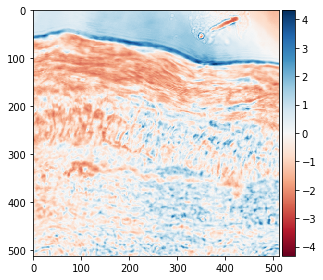

In [206]:
model.save('many 4_class')
imgs_test=imgs_train[1:3]
imgs_mask_test = model.predict(imgs_test, verbose=1,batch_size=1,)
np.save('imgs_mask_test.npy', imgs_mask_test)

sh=np.moveaxis(imgs_test[0],2,0)
imshow(sh[0])

In [207]:
result = imgs_mask_test
result0=result[1]#just one prediction
result0=np.moveaxis(result0,2,0)
print (result.shape)

(2, 512, 512, 4)


(4, 512, 512)
[1 3]


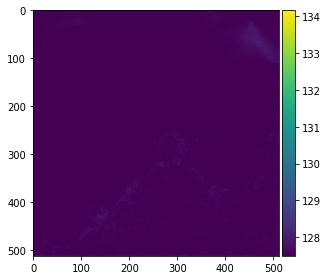

In [208]:
pred=result0
print (pred.shape)
args=np.argmax(pred,axis=0)
imshow(pred[0]*255)
print(np.unique(args))


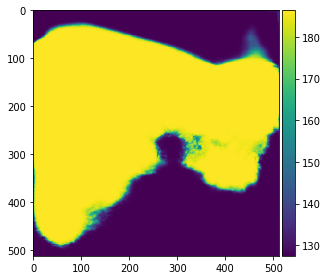

In [209]:
imshow(pred[1]*255)

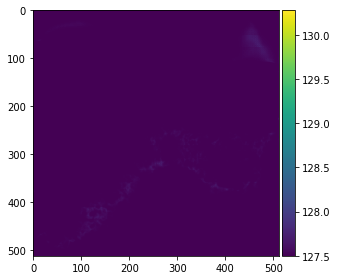

In [210]:
imshow(pred[2]*255)

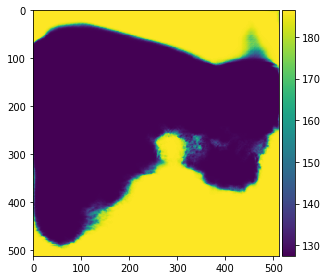

In [211]:
imshow(pred[3]*255)